# General Information
This notebook demotstraits transformation 


https://github.com/goodok/fastai_sparse/blob/master/docs/overview/augmentation.svg


# Imports

In [1]:
import os, sys
import time
import numpy as np
import pandas as pd
import glob
from os.path import join, exists, basename, splitext
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import shutil
from functools import partial
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from IPython.display import display, HTML, FileLink
from PIL import Image as pImage
from ipywidgets import VBox, HBox, Layout
from ipywidgets import widgets
import io

from fastai_sparse import utils, visualize
from fastai_sparse.utils import log
from fastai_sparse.data import DataSourceConfig, MeshesDataset, SparseDataBunch
from fastai_sparse.data_items import MeshItem, PointsItem, SparseItem

from fastai_sparse import transforms as T

# autoreload python modules on the fly when its source is changed
%load_ext autoreload
%autoreload 2

# Experiment environment

In [2]:
experiment_name = 'transforms'

In [3]:
utils.watermark(pandas=True)

virtualenv:     (fastai_sparse) 
python:         3.6.8
nvidia driver:  b'384.130'
nvidia cuda:    9.0, V9.0.176
cudnn:          7.1.4
torch:          1.0.1.post2
pandas:         0.24.2
fastai:         1.0.48
fastai_sparse:  0.0.2.dev0


# Notebook options

In [4]:
utils.wide_notebook()
# uncomment this lines if you want switch off interactive and save visaulisation as screenshoots:
# For rendering run command in terminal:    `chromium-browser --remote-debugging-port=9222`
IS_INTERACTIVE = False
if not IS_INTERACTIVE:
    visualize.options.interactive = False
    visualize.options.save_images = True
    visualize.options.verbose = True
    visualize.options.filename_pattern_image = Path('images', experiment_name, 'fig_{fig_number}')

# Utils

In [5]:
def transform_and_show(x, transforms,
                      original_point_size=1.4, result_point_size=1.4):
    
    b = x.copy().apply_tfms(transforms)
    b.describe()
    
    img_x = x.show(width=480, height=600, point_size_value=original_point_size)
    img_b = b.show(width=480, height=600, point_size_value=result_point_size)
    
    if IS_INTERACTIVE:
        r =  HBox([VBox([widgets.HTML('<div style="text-align: center; width: 100%; font-size:16px">Original</div>'), img_x]),
                   VBox([widgets.HTML('<div style="text-align: center; width: 100%; font-size:16px">Transformed</div>'), img_b,])
                  ])
        return r
    else:

        fig, axes = plt.subplots(ncols=2, figsize=(21, 15))
        ax = axes[0]
        img = pImage.open(io.BytesIO(img_x.data))
        ax.imshow(img)
        ax.set_title('Original', fontsize=14)
        ax.axis('off')

        ax = axes[1]
        img = pImage.open(io.BytesIO(img_b.data))
        ax.imshow(img)
        ax.set_title('Transformed', fontsize=14)
        ax.axis('off')
        plt.subplots_adjust(wspace=0.0, hspace=0)
        plt.show()    

# Read example
read mesh represantation from file

In [6]:
SOURCE_DIR = Path('..', 'samples', 'scannet')
assert SOURCE_DIR.exists()

In [7]:
fn = SOURCE_DIR / 'scene0000_00' / 'scene0000_00.merged.ply'
assert fn.exists()

In [8]:
o = MeshItem.from_file(fn)
o.describe()

MeshItem (scene0000_00.merged.ply)
vertices:                shape: (81369, 3)            dtype: float64        min:   -0.01657,  max:    8.74040,  mean:    3.19051
faces:                   shape: (153587, 3)           dtype: int64          min:          0,  max:      81368,  mean: 40549.68796
colors:                  shape: (81369, 4)            dtype: uint8          min:    1.00000,  max:  255.00000,  mean:  145.80430
labels:                  shape: (81369,)              dtype: uint16         min:    0.00000,  max:  230.00000,  mean:   12.97057
Colors from vertices
Labels from vertices


images/transforms/fig_1.png

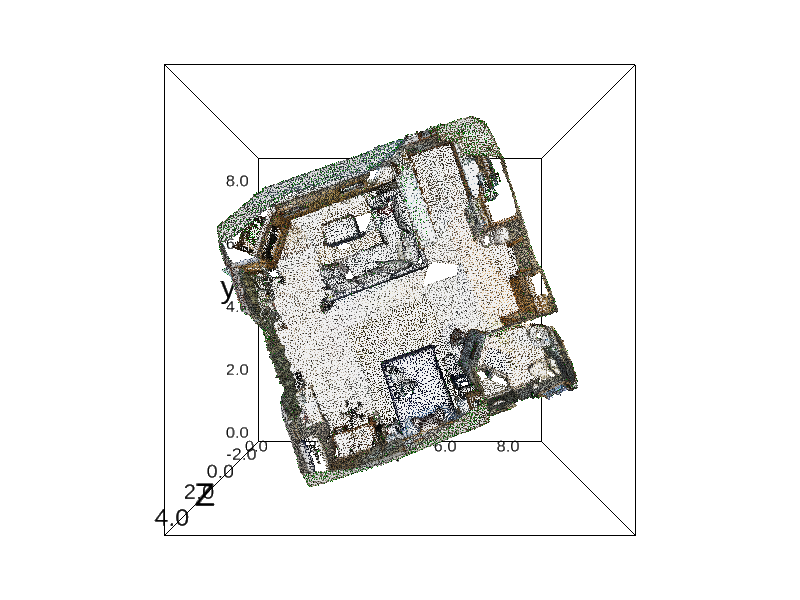

In [9]:
o.show(with_normals=True, point_size_value=0.4)

# Combined transformation
mesh 🡢 points cloud 🡢 sparse voxels

In [10]:
tfms = [
    T.rotate(),
    T.rotate_XY(),
    T.flip_x(p=0.5),
    T.rand_translate(offset=(-2, 2, 3)),
    T.rand_scale(scale=[0.7, 1.3]),
    
    T.fit_to_sphere(),
    T.translate(offset=1),
    T.scale(scale=50),
    
    T.to_points_cloud(method='vertices'),
    T.sample_points(num_points=100000),
    
    T.elastic(gran=8, mag=64),
    
    T.merge_features(ones=False, normals=True, colors=True),
    T.to_sparse_voxels(),
]

In [11]:
np.random.seed(46)

id: scene0000_00.merged
coords                   shape: (81369, 3)            dtype: int64          min:          7,  max:        100,  mean:   53.43846
features                 shape: (81369, 7)            dtype: float32        min:   -0.99999,  max:  255.00000,  mean:   83.26527
x                        shape: (81369,)              dtype: int64          min:         14,  max:        100,  mean:   59.20743
y                        shape: (81369,)              dtype: int64          min:          7,  max:         92,  mean:   52.17837
z                        shape: (81369,)              dtype: int64          min:         34,  max:         81,  mean:   48.92958
labels                   shape: (81369,)              dtype: int64          min:          0,  max:        230,  mean:   12.96269
voxels: 13183
points / voxels: 6.172267313964955


images/transforms/fig_2.png

images/transforms/fig_3.png

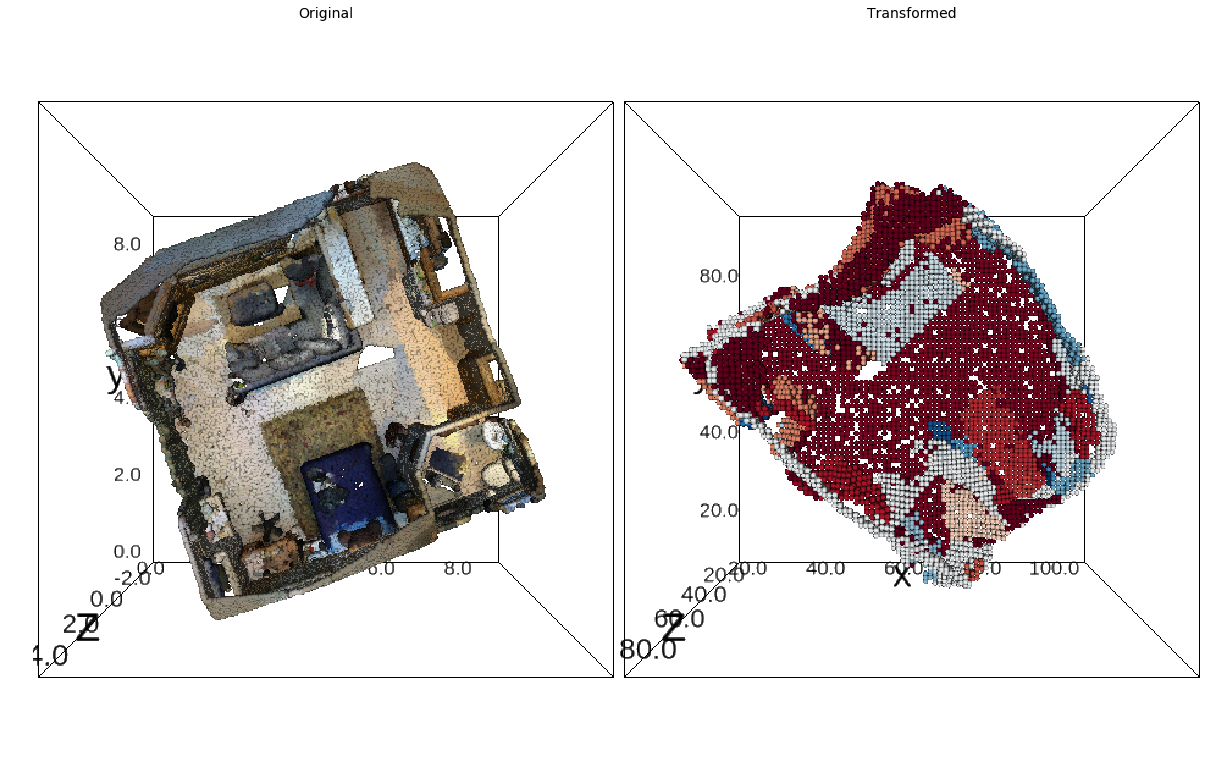

In [12]:
transform_and_show(o, tfms)

# Mesh transforms

## affine

In [13]:
np.random.seed(44)

MeshItem (scene0000_00.merged.ply)
vertices:                shape: (81369, 3)            dtype: float64        min:    7.70902,  max:   93.38925,  mean:   50.00000
faces:                   shape: (153587, 3)           dtype: int64          min:          0,  max:      81368,  mean: 40549.68796
colors:                  shape: (81369, 4)            dtype: uint8          min:    1.00000,  max:  255.00000,  mean:  145.80430
labels:                  shape: (81369,)              dtype: uint16         min:    0.00000,  max:  230.00000,  mean:   12.97057
Colors from vertices
Labels from vertices


images/transforms/fig_4.png

images/transforms/fig_5.png

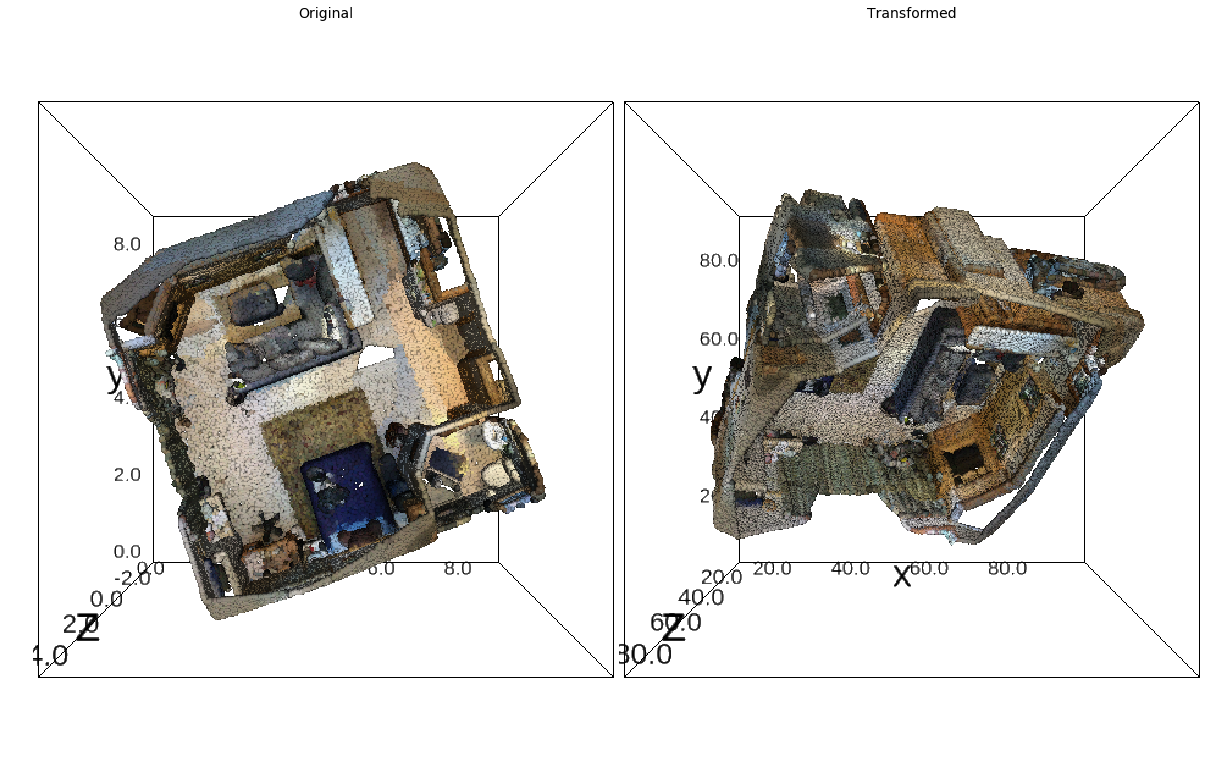

In [14]:
affine = [
    T.rotate(),
    T.rotate_XY(),
    T.flip_x(p=0.5),
    T.rand_translate(offset=(-2, 2, 3)),
    T.rand_scale(scale=[0.7, 1.3]),
    
    T.fit_to_sphere(),
    T.translate(offset=1),
    T.scale(scale=50),  
]
transform_and_show(o, affine)

# Points cloud transforms

In [15]:
np.random.seed(44)

In [16]:
pc = o.copy().apply_tfms(affine)
pc = pc.apply_tfms([T.to_points_cloud(method='vertices')])
#pc.show()

## elastic

In [17]:
np.random.seed(40)

PointsItem (scene0000_00.merged)
points                   shape: (81369, 3)            dtype: float64        min:    5.52502,  max:   94.71804,  mean:   49.73212
labels                   shape: (81369,)              dtype: uint16         min:    0.00000,  max:  230.00000,  mean:   12.97057
colors                   shape: (81369, 4)            dtype: uint8          min:    1.00000,  max:  255.00000,  mean:  145.80430
normals                  shape: (81369, 3)            dtype: float32        min:   -1.00000,  max:    0.99997,  mean:   -0.01491


images/transforms/fig_6.png

images/transforms/fig_7.png

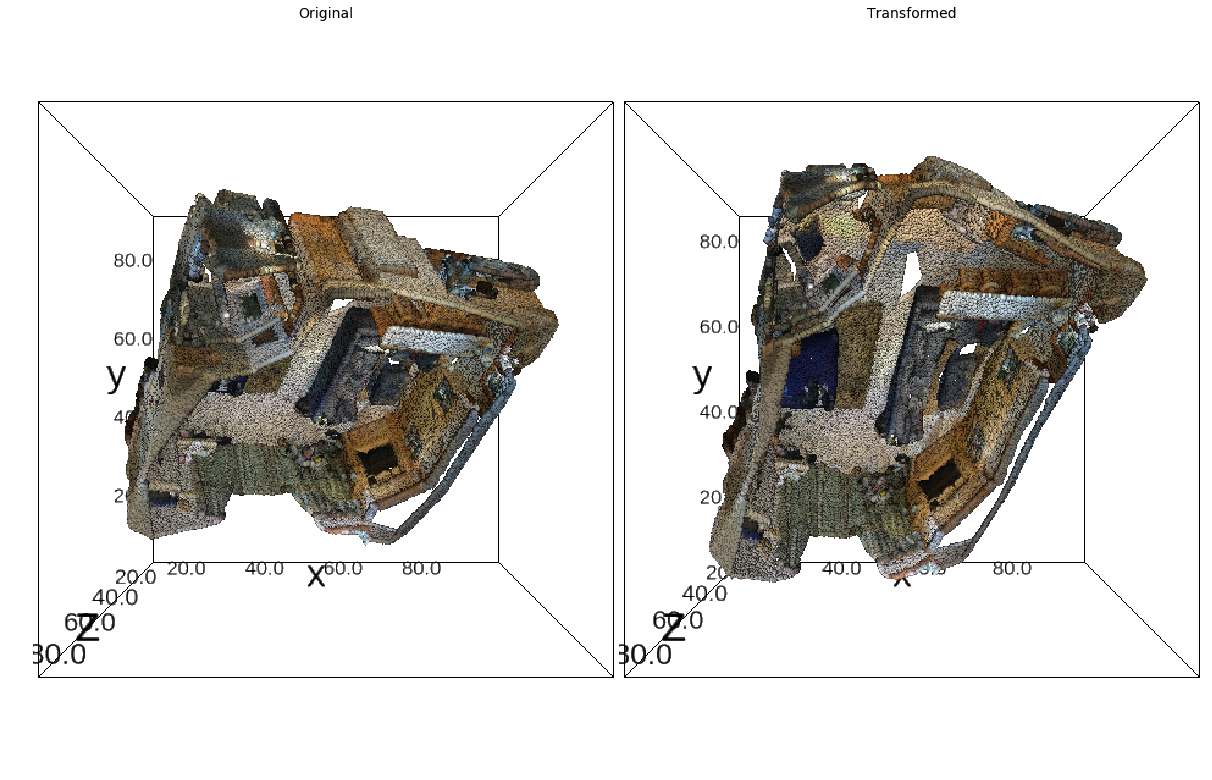

In [18]:
transform_and_show(pc, [T.elastic(gran=8, mag=48)])

# Color transform

##  noise

In [19]:
np.random.seed(0)

PointsItem (scene0000_00.merged)
points                   shape: (81369, 3)            dtype: float32        min:    7.70902,  max:   93.38925,  mean:   50.00000
labels                   shape: (81369,)              dtype: uint16         min:    0.00000,  max:  230.00000,  mean:   12.97057
colors                   shape: (81369, 3)            dtype: float32        min:   -0.92077,  max:    1.17641,  mean:   -0.03715
normals                  shape: (81369, 3)            dtype: float32        min:   -1.00000,  max:    0.99997,  mean:   -0.01491


images/transforms/fig_8.png

images/transforms/fig_9.png

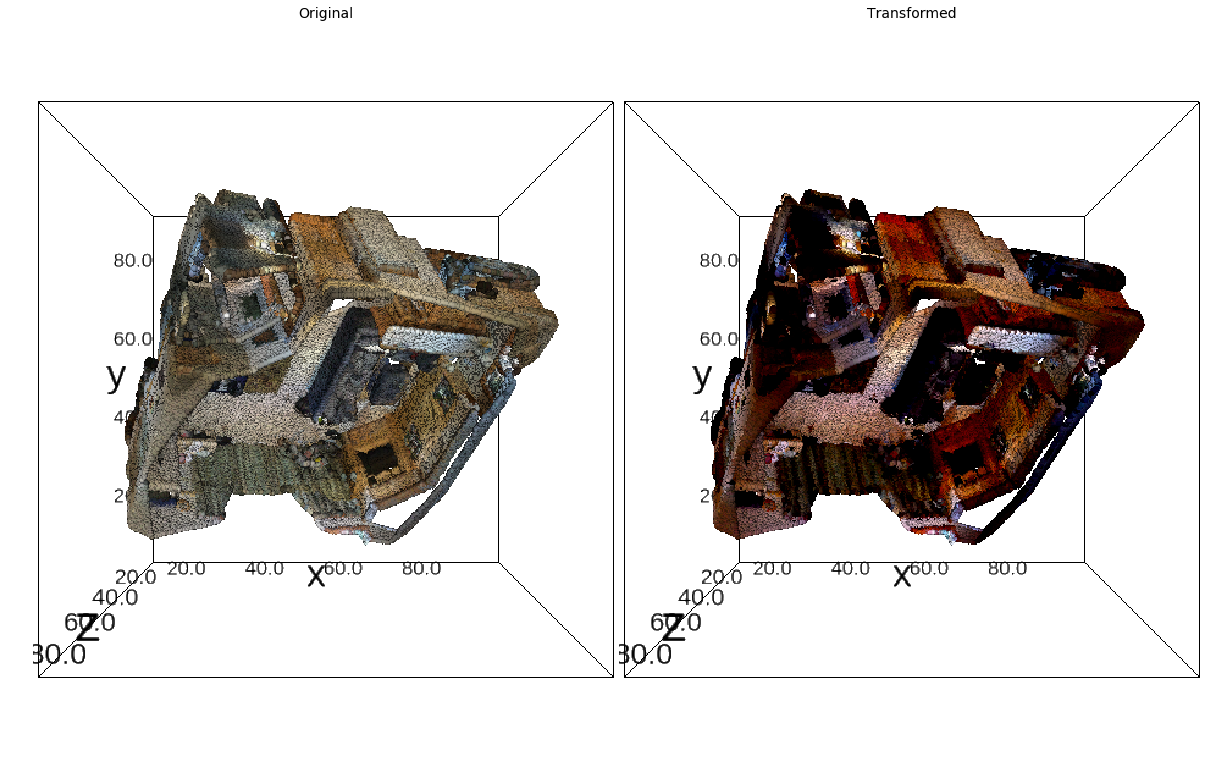

In [20]:
transform_and_show(pc, [T.colors_normalize(), T.colors_noise()])

# Convertation

## from mesh to points cloud

PointsItem (scene0000_00.merged)
points                   shape: (81369, 3)            dtype: float32        min:   -0.01657,  max:    8.74040,  mean:    3.19051
labels                   shape: (81369,)              dtype: uint16         min:    0.00000,  max:  230.00000,  mean:   12.97057
colors                   shape: (81369, 4)            dtype: uint8          min:    1.00000,  max:  255.00000,  mean:  145.80430
normals                  shape: (81369, 3)            dtype: float32        min:   -1.00000,  max:    1.00000,  mean:    0.06483


images/transforms/fig_10.png

images/transforms/fig_11.png

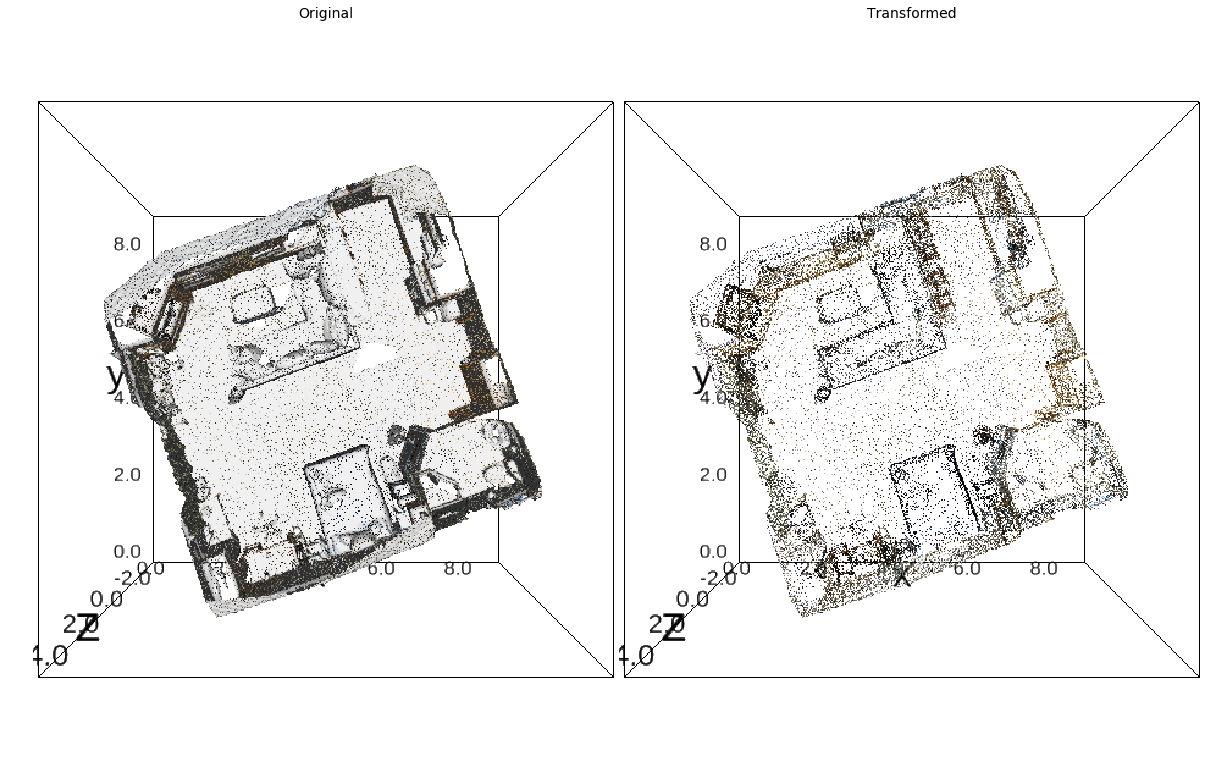

In [21]:
transform_and_show(o, [T.to_points_cloud(method='vertices')],
                   original_point_size=0.2, result_point_size=0.2)

## from points cloud to sparse voxels represantation

id: scene0000_00.merged
coords                   shape: (81369, 3)            dtype: int64          min:          7,  max:         93,  mean:   49.49963
features                 shape: (81369, 5)            dtype: float32        min:    1.00000,  max:  255.00000,  mean:  116.84344
x                        shape: (81369,)              dtype: int64          min:          7,  max:         93,  mean:   49.49961
y                        shape: (81369,)              dtype: int64          min:         11,  max:         80,  mean:   49.50094
z                        shape: (81369,)              dtype: int64          min:         16,  max:         93,  mean:   49.49832
labels                   shape: (81369,)              dtype: int64          min:          0,  max:        230,  mean:   12.97057
voxels: 18269
points / voxels: 4.453938365537249


images/transforms/fig_12.png

images/transforms/fig_13.png

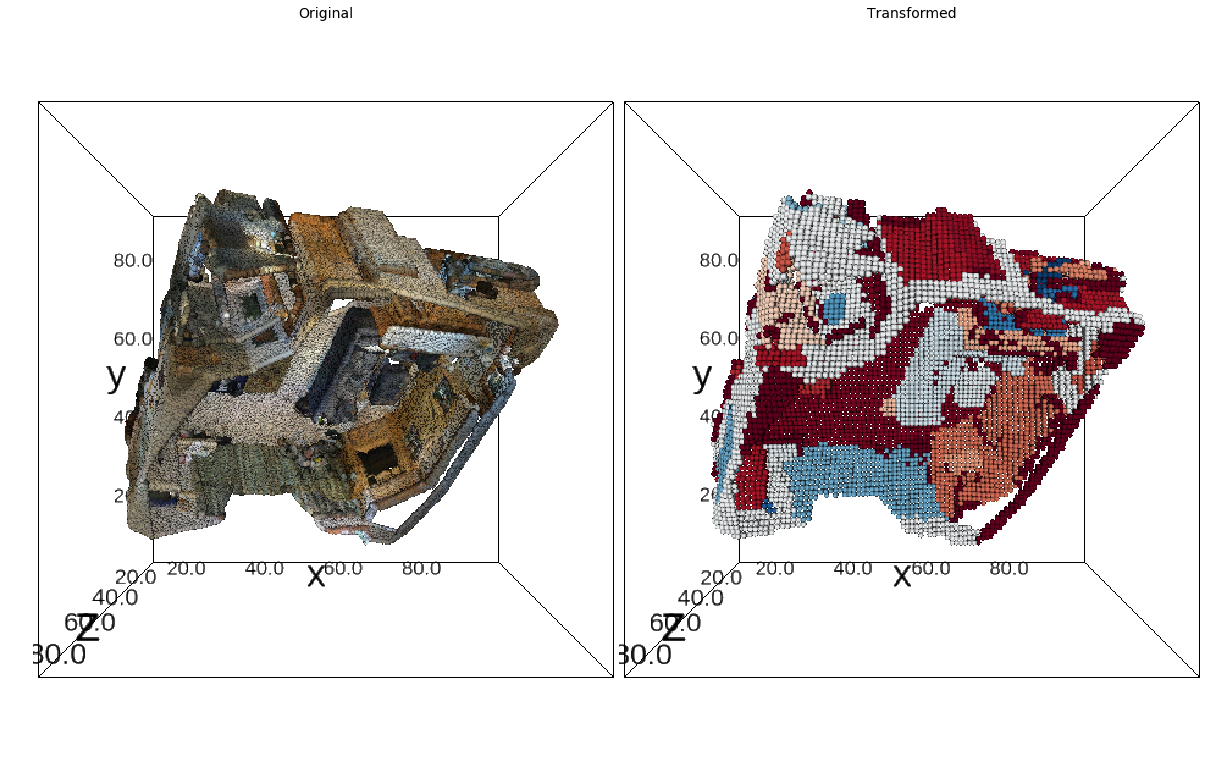

In [22]:
transform_and_show(pc, [T.merge_features(colors=True), T.to_sparse_voxels()])
